# HDBSCAN Clustering for Betacov sequences
---
### DEMO
https://scikit-learn.org/stable/auto_examples/cluster/plot_hdbscan.html#sphx-glr-auto-examples-cluster-plot-hdbscan-py
--- 
### Parquet Making
We will be making a parquet for the entire file. Then we can sample from it randomly.

In [1]:
import os
import tqdm
import torch
import pickle
import numpy as np
import pandas as pd
from torch import nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, EsmModel

import hdbscan
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from umap import UMAP
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, adjusted_rand_score

/data/miniconda3/envs/spike_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Load in the data.

In [2]:
data_dir = "../../data/betacov"

csv_file = os.path.join(data_dir, f"betacoronavirus_seq.csv")
df = pd.read_csv(csv_file, header=0, low_memory=False)
df

,seq_id,variant,host,sequence
0,MN996532,Bat Virus,Bat,NITNLCPFGEVFNATTFASVYAWNRKRISNCVADYSVLYNSTSFST...
1,MG772934,Bat Virus,Bat,NITNVCPFHKVFNATRFPSVYAWERTKISDCIADYTVFYNSTSFST...
2,MG772933,Bat Virus,Bat,NITNVCPFHKVFNATRFPSVYAWERTKISDCIADYTVFYNSTSFST...
3,KT444582,Bat Virus,Bat,NITNLCPFGEVFNATTFPSVYAWERKRISNCVADYSVLYNSTSFST...
4,KY417146,Bat Virus,Bat,NITNLCPFGEVFNATTFPSVYAWERKRISNCVADYSVLYNSTSFST...
...,...,...,...,...
70,AKN24803.1,MERS,Human,AKPSGSVVEQAEGVECDFSPLLSGTPPQVYNFKRLVFTNCNYNFTK...
71,ASU90527.1,MERS,Camel,AKPSGSVVEQAEGVECDFSPLLSGTPPQVYNFKRLVFTNCNYNLTK...
72,AKL59401.1,MERS,Human,AKPSGSVVEQAEGVECDFSPLLSGTPPQVYNFKRLVFTNCNYNLTK...
73,ASY99842.1,MERS,Human,AKPSGSVVEQAEGVECDFSPLLSGTPPQVYNCKRLVFTNCNYNLTK...


In [129]:
df["seq_id"].unique()

array(['MN996532', 'MG772934', 'MG772933', 'KT444582', 'KY417146',
       'KF367457', 'KY417151', 'KY417144', 'KC881005', 'KF569996',
       'KY417142', 'KY417147', 'KY417148', 'KY417143', 'DQ648857',
       'DQ071615', 'GQ153543', 'GQ153548', 'DQ022305', 'KF294457',
       'KJ473815', 'JX993988', 'JX993987', 'KJ473814', 'KJ473816',
       'KJ473811', 'DQ412042', 'DQ648856', 'KJ473812', 'KY417145',
       'EPI_ISL_412977', 'NC014470', 'KY352407', 'AY304486', 'AY304487',
       'AY304489', 'AY613951', 'AY613948', 'AY627045', 'MN908947',
       'AY278741', 'AY278489', 'AY278487', 'AY394979', 'AY394981',
       'AY485277', 'AY525636', 'AY559082', 'AY613947', 'QRN78347.1 ',
       'QWK65230.1', 'EPI_ISL_410544', 'EPI_ISL_410542', 'ALA49363.1',
       'ATG84833.1', 'ALA49374.1', 'AHZ58501.1', 'ALA49836.1',
       'ANF29239.1', 'AKO69634.1', 'ALJ54491.1', 'ANC28634.1',
       'AID55088.1', 'ALJ54446.1', 'ALA50067.1', 'ALK80291.1',
       'AGV08379.1', 'ALJ54518.1', 'AHY22545.1', 'ASU90329.1'

In [167]:
bats = df[df['variant'].isin(["Bat Virus"])]
bats['seq_id'].unique()

array(['MN996532', 'MG772934', 'MG772933', 'KT444582', 'KY417146',
       'KF367457', 'KY417151', 'KY417144', 'KC881005', 'KF569996',
       'KY417142', 'KY417147', 'KY417148', 'KY417143', 'DQ648857',
       'DQ071615', 'GQ153543', 'GQ153548', 'DQ022305', 'KF294457',
       'KJ473815', 'JX993988', 'JX993987', 'KJ473814', 'KJ473816',
       'KJ473811', 'DQ412042', 'DQ648856', 'KJ473812', 'KY417145',
       'EPI_ISL_412977', 'NC014470', 'KY352407'], dtype=object)

Making the parquet.

In [5]:
# Parquet Making
class RBDDataset(Dataset):
    """ BetaCorona virus sequence dataset, embedded with ESM model. """

    def __init__(self, csv_file:str):
        self.df = pd.read_csv(csv_file, header=0, na_filter=False)
        self.max_sequence_length = self.df['sequence'].apply(len).max()

    def __len__(self) -> int:
        return len(self.df)

    def __getitem__(self, idx):
        columns = (
            self.df.iloc[idx]["seq_id"],
            self.df.iloc[idx]["variant"],
            self.df.iloc[idx]["host"],
            self.df.iloc[idx]["sequence"],
        )
        return columns

class ESM(nn.Module):
    def __init__(self, esm):
        super().__init__()
        self.esm = esm

    def forward(self, tokenized_seqs):
        with torch.set_grad_enabled(self.training):  # Enable gradients, managed by model.eval() or model.train() in epoch_iteration
            last_hidden_states = self.esm(**tokenized_seqs).last_hidden_state # shape: (batch_size, sequence_length, embedding_dim)
            cls_embedding = last_hidden_states[:, 0, :]  # CLS token embedding (sequence-level representations)
        return cls_embedding

def run_model(model, tokenizer, dataloader, device, csv_file):   
    """ Call the ESM model to generate hidden states and store batch data in DataFrame directly. """
    
    model = model.to(device)
    model.eval()

    # Set the tqdm progress bar
    data_iter = tqdm.tqdm(enumerate(dataloader),
                          total = len(dataloader),
                          bar_format='{l_bar}{r_bar}')

    batch_dataframes = []

    for _, batch_data in data_iter:
        seq_ids, variants, hosts, sequences = batch_data 

        # Add 2 to max_length to account for additional tokens added to beginning and end by ESM
        max_length = dataloader.dataset.max_sequence_length + 2
        tokenized_seqs = tokenizer(sequences, return_tensors='pt', padding='max_length', max_length=max_length).to(device) 
        
        with torch.no_grad():
            embeddings = model(tokenized_seqs) # shape: [batch_size, sequence_len, embedding_dim]

        # Create a DataFrame for the batch
        batch_df = pd.DataFrame({
            "seq_id": seq_ids,
            "variant": variants,
            "host": hosts,
            "embedding": [embedding.cpu().numpy() for embedding in embeddings]  # Convert tensor to numpy array for each embedding
        })

        batch_dataframes.append(batch_df)

    # Concatenate all batch DataFrames into one
    result_df = pd.concat(batch_dataframes, ignore_index=True)
    
    # Save data to a Parquet file
    save_as = csv_file.replace(".csv", "_CLS-embedded.parquet")
    result_df.to_parquet(save_as, index=False)
    print(f"Data saved to {save_as}")

# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
batch_size = 64

# Data file
data_dir = "../../data/betacov"
csv_file = os.path.join(data_dir, f"betacoronavirus_seq.csv")
dataset = RBDDataset(csv_file)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, drop_last=False)

# ESM input
esm_version = "facebook/esm2_t6_8M_UR50D"
esm = EsmModel.from_pretrained(esm_version, cache_dir='../model_downloads').to(device)
tokenizer = AutoTokenizer.from_pretrained(esm_version, cache_dir='../model_downloads')

model = ESM(esm)
run_model(model, tokenizer, dataloader, device, csv_file)

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['esm.pooler.dense.weight', 'esm.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|| 2/2 [00:00<00:00, 10.07it/s]


Data saved to ../../data/betacov/betacoronavirus_seq_CLS-embedded.parquet


### Clustering - tSNE, then HDBSCAN
Apply tSNE to the embeddings, then save the tSNE embeddings.

In [48]:
def plot_from_embedding(save_as, info_df, embedding_matrix, type, color_map):
    embeddings_df = pd.DataFrame(embedding_matrix, columns=['DIM_1', 'DIM_2']).reset_index(drop=True)
    df = pd.concat([info_df, embeddings_df], axis=1)

    # Custom color mapping for specified variants  
    variant_labels = sorted(df["variant"].unique())
    colors = sns.color_palette(color_map, len(variant_labels))
    variant_colors = dict(zip(variant_labels, colors))
    df['colors'] = df['variant'].map(variant_colors)

    # Create a scatter plot
    plt.figure(figsize=(10, 8))
    plt.rcParams['font.family'] = 'sans-serif'

    # Plot each variant separately so each can be labeled
    for variant in variant_labels:
        subset = df[df['variant'] == variant]
        plt.scatter(subset['DIM_1'], subset['DIM_2'], c=[variant_colors[variant]], label=variant, s=20, alpha=0.8)

    plt.xlabel(f'{type} Dimension 1')
    plt.ylabel(f'{type} Dimension 2')

    # Create a legend
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

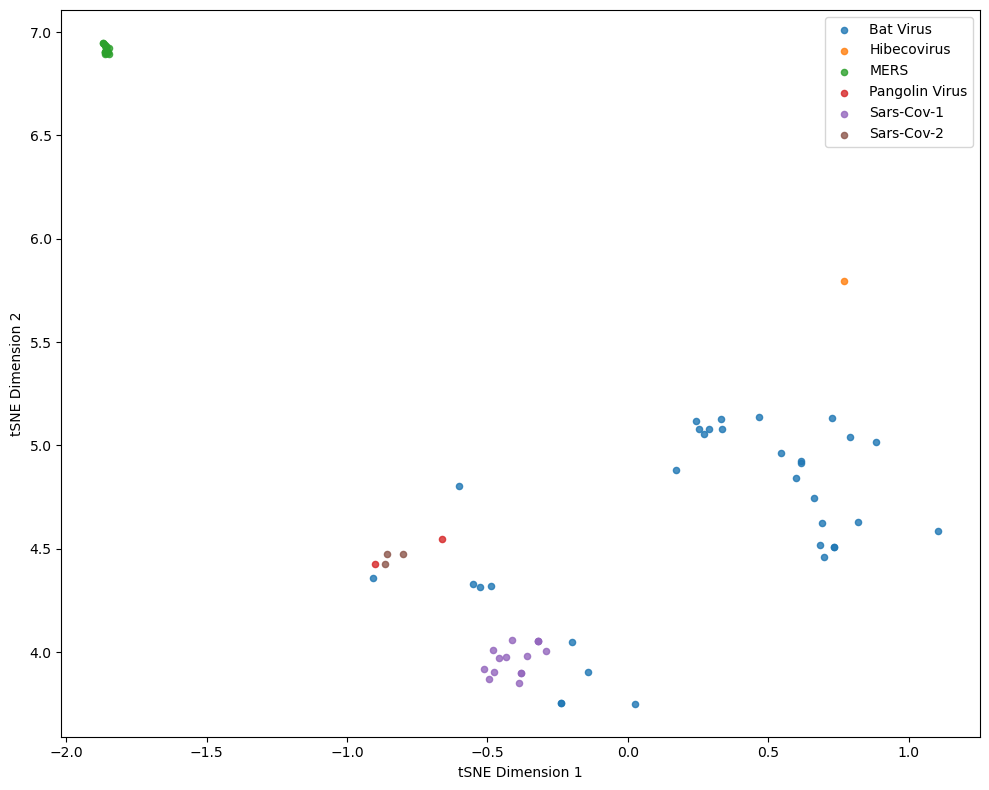

In [89]:
# Load in the data
parquet_file = os.path.join(data_dir, f"betacoronavirus_seq_CLS-embedded.parquet")
embedded_ado_df = pd.read_parquet(parquet_file, engine='fastparquet')
embedding_matrix = np.vstack(embedded_ado_df["embedding"])
info_df = embedded_ado_df.drop(columns=["embedding"])

# Apply tSNE to reduce the dimensionality of the embedding matrix
perplexity = 50
tsne_reducer = TSNE(n_components=2, perplexity=perplexity, learning_rate='auto', random_state=0)
embedding_matrix_reduced = tsne_reducer.fit_transform(embedding_matrix)
plot_from_embedding("", info_df, embedding_matrix_reduced, 'tSNE', "tab10")

# Save the embedding
embeddings_df = pd.DataFrame(embedding_matrix_reduced, columns=['DIM_1', 'DIM_2']).reset_index(drop=True)
tsne_df = pd.concat([info_df, embeddings_df], axis=1)
save_as = os.path.join(data_dir, f"betacoronavirus_seq_CLS-embedded.tsne.parquet")
tsne_df.to_parquet(save_as, engine='fastparquet')

Load the tSNE emeddings.

In [90]:
# Load the embedding
parquet_file = os.path.join(data_dir, f"betacoronavirus_seq_CLS-embedded.tsne.parquet")
embedded_ado_df = pd.read_parquet(parquet_file, engine='fastparquet')
embedding_matrix_reduced = embedded_ado_df[['DIM_1', 'DIM_2']].values
info_df = embedded_ado_df.drop(columns=['DIM_1', 'DIM_2'])

Find highest or a sufficiently highest Silhouette Coefficient, Adjusted Rand Index.

In [91]:
for i in [1,2,3,4,5,6]:
    for j in [2,3,4,5,6]:
        # Cluster
        hdb_labels = hdbscan.HDBSCAN(
            min_samples=i,
            min_cluster_size=j,
            core_dist_n_jobs=-1  # Enable parallel processing
        ).fit(embedding_matrix_reduced).labels_

        # Evaluate clustering
        silhouette_avg = silhouette_score(embedding_matrix_reduced, hdb_labels)
        ari = adjusted_rand_score(info_df["variant"], hdb_labels)
        print(f"min_sample {i}, min_cluster_size {j}: (Silhouette Coefficient {silhouette_avg:.2f}, Adjusted Rand Index {ari:.2f})")

min_sample 1, min_cluster_size 2: (Silhouette Coefficient 0.43, Adjusted Rand Index 0.18)
min_sample 1, min_cluster_size 3: (Silhouette Coefficient 0.39, Adjusted Rand Index 0.19)
min_sample 1, min_cluster_size 4: (Silhouette Coefficient 0.56, Adjusted Rand Index 0.33)
min_sample 1, min_cluster_size 5: (Silhouette Coefficient 0.57, Adjusted Rand Index 0.37)
min_sample 1, min_cluster_size 6: (Silhouette Coefficient 0.57, Adjusted Rand Index 0.37)
min_sample 2, min_cluster_size 2: (Silhouette Coefficient 0.42, Adjusted Rand Index 0.17)
min_sample 2, min_cluster_size 3: (Silhouette Coefficient 0.38, Adjusted Rand Index 0.19)
min_sample 2, min_cluster_size 4: (Silhouette Coefficient 0.53, Adjusted Rand Index 0.34)
min_sample 2, min_cluster_size 5: (Silhouette Coefficient 0.54, Adjusted Rand Index 0.37)
min_sample 2, min_cluster_size 6: (Silhouette Coefficient 0.54, Adjusted Rand Index 0.37)
min_sample 3, min_cluster_size 2: (Silhouette Coefficient 0.52, Adjusted Rand Index 0.34)
min_sample

Plotting the tSNE embeddings after applying HDBSCAN.

In [124]:
def plot_hdbscan_with_groups(save_as, info_df, embedding_matrix, hdb_labels, data_column, group_column, colormap):
    # Color map for ground truth
    unique_data_values = info_df[data_column].unique()
    ground_truth_colors = sns.color_palette(colormap, n_colors=len(unique_data_values))
    ground_truth_color_dict = dict(zip(unique_data_values, ground_truth_colors))

    # Color map for HDBSCAN clusters
    unique_clusters = np.unique(hdb_labels)
    if (len(unique_clusters)-1) > 10:
        cluster_colors = sns.color_palette("colorblind", 10) + sns.color_palette(["#999933", "#882255", "#661100", "#6699CC", "#332288"])
    else:
        cluster_colors = sns.color_palette(colormap, n_colors=len(unique_clusters)-1)  # -1 to exclude outliers
    cluster_color_dict = {label: color for label, color in zip(unique_clusters[unique_clusters != -1], cluster_colors)}
    cluster_color_dict[-1] = 'black'  # Outliers are black

    # Marker shapes for different groups
    unique_groups = info_df[group_column].unique()
    markers = ['o', '^', 's', 'P', '*', 'D', 'v', 'p', '.']
    group_marker_dict = dict(zip(unique_groups, markers))

    n_predicted_clusters = len(unique_clusters) - (1 if -1 in unique_clusters else 0)
    n_true_clusters = len(unique_data_values)

    fig, axes = plt.subplots(1, 2, figsize=(20, 8))
    fontsize = 20

    # Left subplot: HDBSCAN clusters (Predicted)
    ax = axes[0]
    ax.set_title(f'Predicted: {n_predicted_clusters} clusters', fontsize=fontsize)
    for label in unique_clusters:
        for group in unique_groups:
            mask = (hdb_labels == label) & (info_df[group_column] == group)
            if label == -1:
                ax.scatter(embedding_matrix[mask, 0], embedding_matrix[mask, 1],
                           c='black', label='Outliers', marker='x', s=50)
            else:
                ax.scatter(embedding_matrix[mask, 0], embedding_matrix[mask, 1],
                           c=[cluster_color_dict[label]], marker=group_marker_dict[group],
                           label=f'Cluster {label} ({group})', s=250, alpha=0.5)

    legend_handles_predicted = []
    legend_handles_predicted.append(plt.Line2D([0], [0], marker='x', color='black', linestyle='none', markersize=7, label='Outliers'))
    legend_handles_predicted += [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=cluster_color_dict[label], markersize=10, label=f'Cluster {label}')
        for label in unique_clusters if label != -1
    ]
    legend_handles_predicted.append(plt.Line2D([0], [0], marker='', color='none', label='', markersize=0))  # blank
    legend_handles_predicted += [
        plt.Line2D([0], [0], marker=group_marker_dict[group], color='w', markerfacecolor='black', markersize=10, label=group)
        for group in unique_groups
    ]

    # Right subplot: Ground truth
    ax2 = axes[1]
    ax2.set_title(f'Ground Truth: {n_true_clusters} clusters', fontsize=fontsize)
    for value in unique_data_values:
        for group in unique_groups:
            mask = (info_df[data_column] == value) & (info_df[group_column] == group)
            ax2.scatter(embedding_matrix[mask, 0], embedding_matrix[mask, 1],
                        c=[ground_truth_color_dict[value]], marker=group_marker_dict[group],
                        label=f'{value} ({group})', s=250, alpha=0.5)

    legend_handles_ground_truth = []    
    legend_handles_ground_truth += [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=ground_truth_color_dict[value], markersize=10, label=value)
        for value in unique_data_values
    ]
    legend_handles_ground_truth.append(plt.Line2D([0], [0], marker='', color='none', label='', markersize=0))  # blank
    legend_handles_ground_truth += [
        plt.Line2D([0], [0], marker=group_marker_dict[group], color='w', markerfacecolor='black', markersize=10, label=group)
        for group in unique_groups
    ]

    for ax in axes:
        ax.set_xlabel('Component 1', fontsize=fontsize)
        ax.set_ylabel('Component 2', fontsize=fontsize)
        ax.tick_params(axis='both', which='major', labelsize=fontsize)

    axes[0].legend(handles=legend_handles_predicted, loc='center left', fontsize=fontsize-6)
    axes[1].legend(handles=legend_handles_ground_truth, loc='center left', fontsize=fontsize-6)

    plt.tight_layout()
    plt.savefig(f"{save_as}.pdf", format="pdf")
    plt.savefig(f"{save_as}.png", format="png")
    plt.show()

In [174]:
def plot_hdbscan_with_groups_pts_labeled(save_as, info_df, embedding_matrix, hdb_labels, data_column, group_column, colormap, points_to_label=None):
    # Color map for ground truth
    unique_data_values = info_df[data_column].unique()
    ground_truth_colors = sns.color_palette(colormap, n_colors=len(unique_data_values))
    ground_truth_color_dict = dict(zip(unique_data_values, ground_truth_colors))

    # Color map for HDBSCAN clusters
    unique_clusters = np.unique(hdb_labels)
    if (len(unique_clusters)-1) > 10:
        cluster_colors = sns.color_palette("colorblind", 10) + sns.color_palette(["#999933", "#882255", "#661100", "#6699CC", "#332288"])
    else:
        cluster_colors = sns.color_palette(colormap, n_colors=len(unique_clusters)-1)  # -1 to exclude outliers
    cluster_color_dict = {label: color for label, color in zip(unique_clusters[unique_clusters != -1], cluster_colors)}
    cluster_color_dict[-1] = 'black'  # Outliers are black

    # Marker shapes for different groups
    unique_groups = info_df[group_column].unique()
    markers = ['o', '^', 's', 'P', '*', 'D', 'v', 'p', '.']
    group_marker_dict = dict(zip(unique_groups, markers))

    n_predicted_clusters = len(unique_clusters) - (1 if -1 in unique_clusters else 0)
    n_true_clusters = len(unique_data_values)

    fig, axes = plt.subplots(1, 2, figsize=(20, 8))
    fontsize = 20

    # Left subplot: HDBSCAN clusters (Predicted)
    ax = axes[0]
    ax.set_title(f'Predicted: {n_predicted_clusters} clusters', fontsize=fontsize)
    for label in unique_clusters:
        for group in unique_groups:
            mask = (hdb_labels == label) & (info_df[group_column] == group)
            if label == -1:
                ax.scatter(embedding_matrix[mask, 0], embedding_matrix[mask, 1],
                           c='black', label='Outliers', marker='x', s=50)
            else:
                ax.scatter(embedding_matrix[mask, 0], embedding_matrix[mask, 1],
                           c=[cluster_color_dict[label]], marker=group_marker_dict[group],
                           label=f'Cluster {label} ({group})', s=250, alpha=0.5)
    
    legend_handles_predicted = []
    legend_handles_predicted.append(plt.Line2D([0], [0], marker='x', color='black', linestyle='none', markersize=7, label='Outliers'))
    legend_handles_predicted += [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=cluster_color_dict[label], markersize=10, label=f'Cluster {label}')
        for label in unique_clusters if label != -1
    ]
    legend_handles_predicted.append(plt.Line2D([0], [0], marker='', color='none', label='', markersize=0))  # blank
    legend_handles_predicted += [
        plt.Line2D([0], [0], marker=group_marker_dict[group], color='w', markerfacecolor='black', markersize=10, label=group)
        for group in unique_groups
    ]

    # Right subplot: Ground truth
    ax2 = axes[1]
    ax2.set_title(f'Ground Truth: {n_true_clusters} clusters', fontsize=fontsize)
    for value in unique_data_values:
        for group in unique_groups:
            mask = (info_df[data_column] == value) & (info_df[group_column] == group)
            ax2.scatter(embedding_matrix[mask, 0], embedding_matrix[mask, 1],
                        c=[ground_truth_color_dict[value]], marker=group_marker_dict[group],
                        label=f'{value} ({group})', s=250, alpha=0.5)

    legend_handles_ground_truth = []    
    legend_handles_ground_truth += [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=ground_truth_color_dict[value], markersize=10, label=value)
        for value in unique_data_values
    ]
    legend_handles_ground_truth.append(plt.Line2D([0], [0], marker='', color='none', label='', markersize=0))  # blank
    legend_handles_ground_truth += [
        plt.Line2D([0], [0], marker=group_marker_dict[group], color='w', markerfacecolor='black', markersize=10, label=group)
        for group in unique_groups
    ]

    # Label specific points
    if points_to_label is not None:
        for seq_id in points_to_label:
            if seq_id in info_df['seq_id'].values:
                idx = info_df[info_df['seq_id'] == seq_id].index[0]
                x, y = embedding_matrix[idx]
                group = info_df.loc[idx, group_column]
                marker = group_marker_dict[group]
                for ax in axes:
                    ax.scatter(x, y, facecolors='none', edgecolors='k', s=250, linewidths=1, 
                               marker=marker, zorder=5)  # Outline the labeled point in red
                    ax.annotate(seq_id, (x, y), xytext=(-70, 10), textcoords='offset points', fontsize=fontsize-8)

    for ax in axes:
        ax.set_xlabel('Component 1', fontsize=fontsize)
        ax.set_ylabel('Component 2', fontsize=fontsize)
        ax.tick_params(axis='both', which='major', labelsize=fontsize)

    axes[0].legend(handles=legend_handles_predicted, loc='center left', fontsize=fontsize-6)
    axes[1].legend(handles=legend_handles_ground_truth, loc='center left', fontsize=fontsize-6)

    plt.tight_layout()
    plt.savefig(f"{save_as}.pdf", format="pdf")
    plt.savefig(f"{save_as}.png", format="png")
    plt.show()

min_sample 4, min_cluster_size 6: Silhouette Coefficient: 0.68, Adjusted Rand Index: 0.69


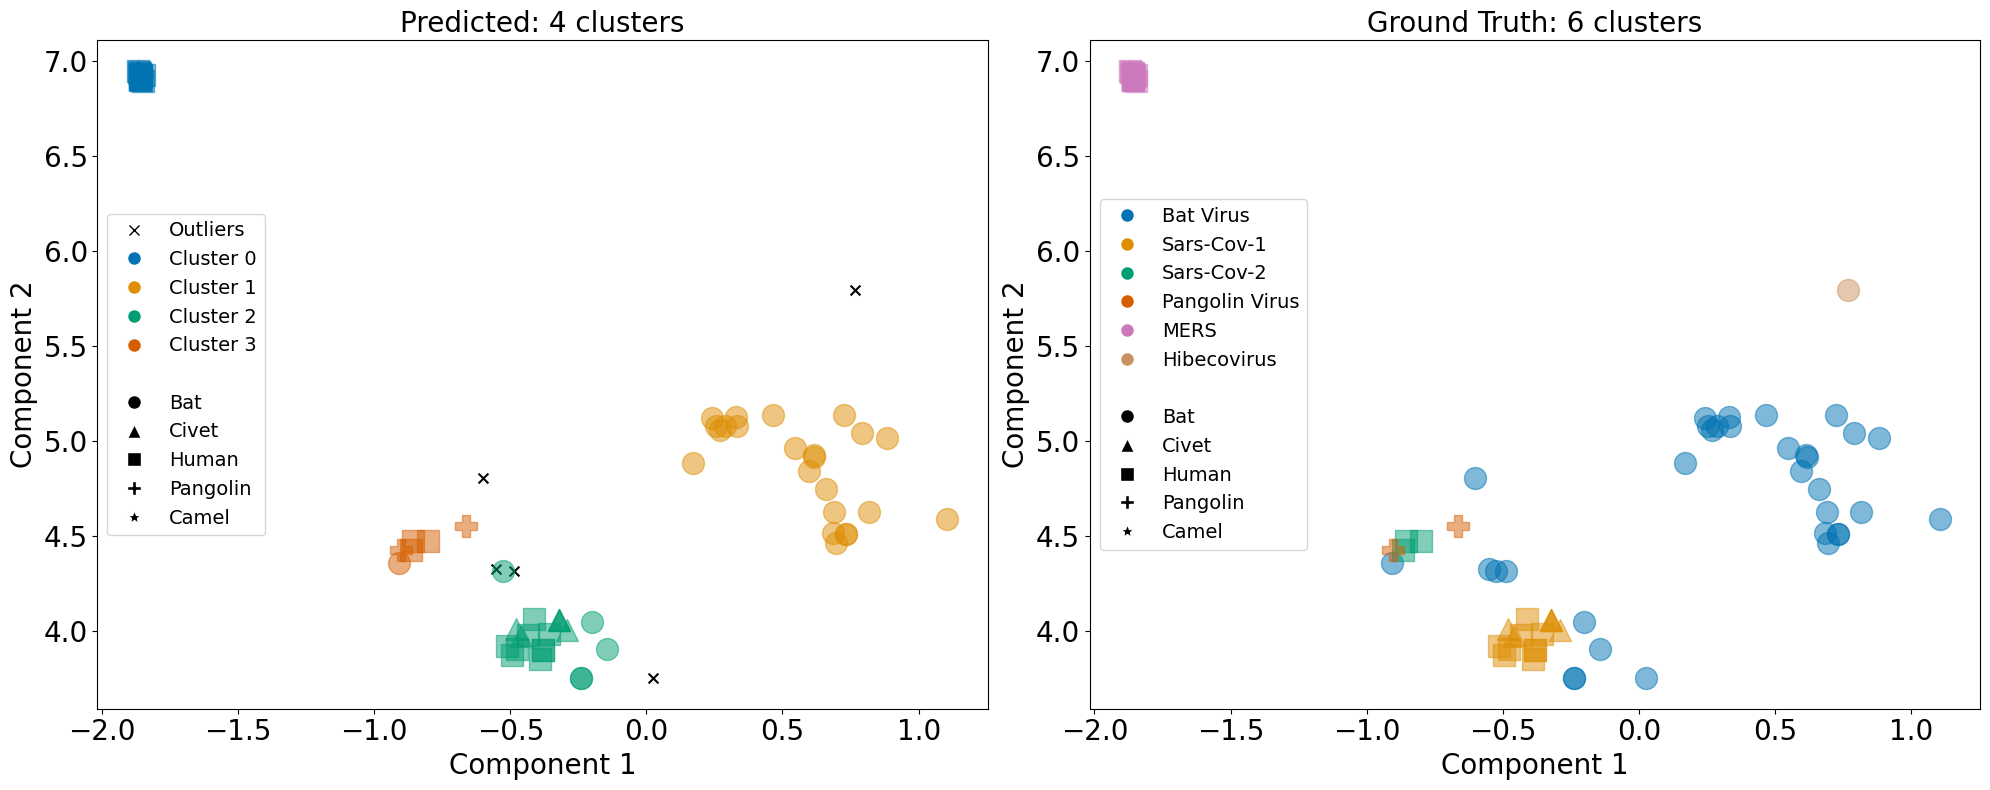

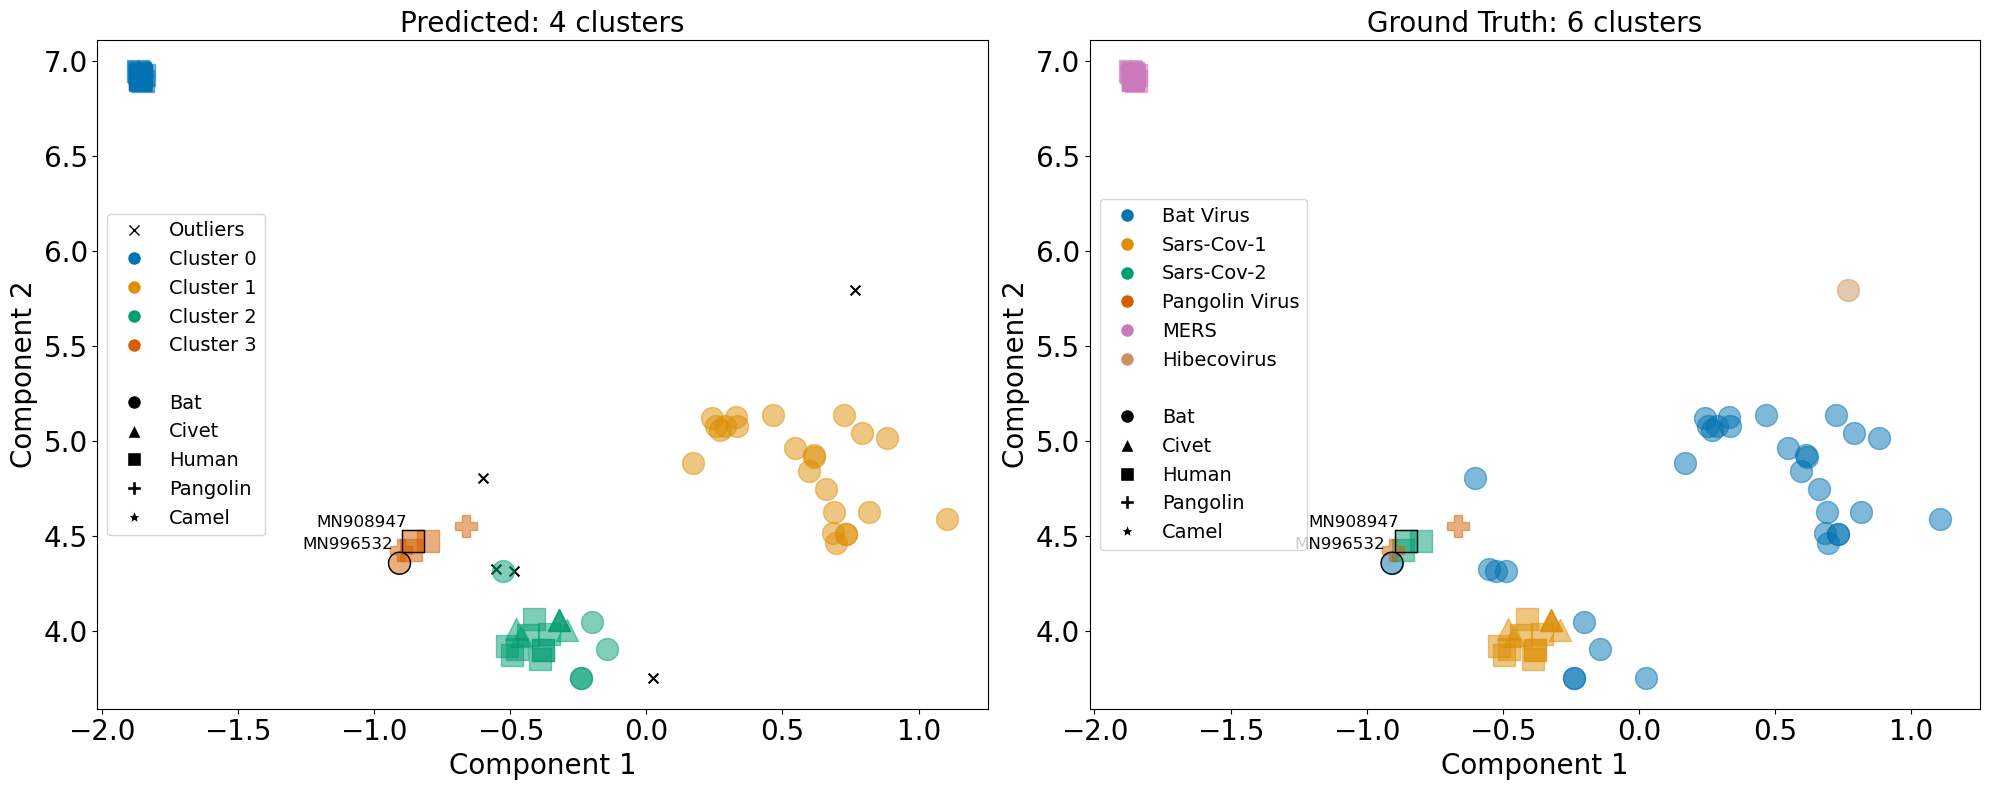

Predicted Clusters,-1,0,1,2,3
Ground Truth,,,,,
Bat Virus,12.12,0.0,69.7,15.15,3.03
Hibecovirus,100.00,0.0,0.0,0.00,0.00
MERS,0.00,100.0,0.0,0.00,0.00
Pangolin Virus,0.00,0.0,0.0,0.00,100.00
Sars-Cov-1,0.00,0.0,0.0,100.00,0.00
Sars-Cov-2,0.00,0.0,0.0,0.00,100.00


In [203]:
min_samples=4
min_cluster_size=6

# Cluster
hdb_labels = hdbscan.HDBSCAN(
    min_samples=min_samples,
    min_cluster_size=min_cluster_size,
    core_dist_n_jobs=-1  # Enable parallel processing
).fit(embedding_matrix_reduced).labels_

# Evaluate clustering
silhouette_avg = silhouette_score(embedding_matrix_reduced, hdb_labels)
ari = adjusted_rand_score(info_df["variant"], hdb_labels)
print(f"min_sample {min_samples}, min_cluster_size {min_cluster_size}: Silhouette Coefficient: {silhouette_avg:.2f}, Adjusted Rand Index: {ari:.2f}")
save_as = f"../../results/plots/clustering/BETACOV.tSNE-perp{perplexity}.HDBSCAN-ms{min_samples}_mcs{min_cluster_size}-sc{silhouette_avg:.2f}_ari{ari:.2f}"
plot_hdbscan_with_groups(save_as, info_df, embedding_matrix_reduced, hdb_labels, "variant", "host", "colorblind")

points_to_label = ['MN908947', 'MN996532']  # Replace with actual seq_ids you want to label
plot_hdbscan_with_groups_pts_labeled(save_as, info_df, embedding_matrix_reduced, hdb_labels, "variant", "host", "colorblind", points_to_label=points_to_label)

# Create the truth table
truth_table_percent = pd.crosstab(info_df["variant"], hdb_labels, 
                                rownames=['Ground Truth'], 
                                colnames=['Predicted Clusters'],
                                normalize='index')  # Normalize along the index (rows)
truth_table_percent = (truth_table_percent * 100).round(2)
truth_table_percent